# Introduction to Machine Learning Systems

### [Eric Meissner](https://www.linkedin.com/in/meissnereric/)

### [Andrei Paleyes](https://www.linkedin.com/in/andreipaleyes/)

### [Neil D. Lawrence](http://inverseprobability.com)

### 2021-10-06

**Abstract**: This session introduces some of the challenges of building
machine learning data systems. It will introduce you to concepts around
joining of databases together. The storage and manipulation of data is
at the core of machine learning systems and data science. The goal of
this notebook is to introduce the reader to these concepts, not to
authoritatively answer any questions about the state of Nigerian health
facilities or Covid19, but it may give you ideas about how to try and do
that in your own country.

$$
$$

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

## Question

In this notebook, we explore the question of health facility
distribution in Nigeria, spatially, and in relation to population
density.

We answer and visualize the question “How does the number of health
facilities per capita vary across Nigeria?”

Rather than focussing purely on using tools like `pandas` to manipulate
the data, our focus will be on introducing some concepts from databases.

Machine learning can be summarized as $$
\text{model} + \text{data} \xrightarrow{\text{compute}} \text{prediction}
$$ and many machine learning courses focus a lot on the model part. But
to build a machine learning system in practice, a lot of work must be
put into the data part. This notebook gives some pointers on that work
and how to think about your machine learning systems design.

## Datasets

In this notebook, we download 4 datasets:

-   Nigeria NMIS health facility data
-   Population data for Administrative Zone 1 (states) areas in Nigeria
-   Map boundaries for Nigerian states (for plotting and binning)
-   Covid cases across Nigeria (as of May 20, 2020)

But joining these data sets together is just an example. As another
example, you could think of [SafeBoda](https://safeboda.com/ng/), a
ride-hailing app that’s available in Lagos and Kampala. As well as
looking at the health examples, try to imagine how SafeBoda may have had
to design their systems to be scalable and reliable for storing and
sharing data.

## Imports, Installs, and Downloads

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-installs.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-installs.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

First, we’re going to download some particular python libraries for
dealing with geospatial data. We’re dowloading
[`geopandas`](https://geopandas.org) which will help us deal with ‘shape
files’ that give the geographical lay out of Nigeria. We also need
`pygeos` for indexing.

In [105]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [106]:
%pip install pygeos

Note: you may need to restart the kernel to use updated packages.


In [107]:
%pip install decarteslabs[complete]

ERROR: Could not find a version that satisfies the requirement decarteslabs[complete]
ERROR: No matching distribution found for decarteslabs[complete]
Note: you may need to restart the kernel to use updated packages.


## Setup

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_notebooks/includes/notebook-setup.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_notebooks/includes/notebook-setup.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In [108]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<!--setupplotcode{import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set_palette('colorblind')}-->

## notutils

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/notutils-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/notutils-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

This small package is a helper package for various notebook utilities
used

The software can be installed using

In [109]:
%pip install notutils

Note: you may need to restart the kernel to use updated packages.


from the command prompt where you can access your python installation.

The code is also available on GitHub:
<https://github.com/lawrennd/notutils>

Once `notutils` is installed, it can be imported in the usual manner.

In [110]:
import notutils

## mlai

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/mlai-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/mlai-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The `mlai` software is a suite of helper functions for teaching and
demonstrating machine learning algorithms. It was first used in the
Machine Learning and Adaptive Intelligence course in Sheffield in 2013.

The software can be installed using

In [111]:
%pip install mlai

Note: you may need to restart the kernel to use updated packages.


from the command prompt where you can access your python installation.

The code is also available on GitHub: <https://github.com/lawrennd/mlai>

Once `mlai` is installed, it can be imported in the usual manner.

In [112]:
import mlai

## Databases and Joins

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/databases-and-joins.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/databases-and-joins.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The main idea we will be working with today is called the ‘join.’ A join
does exactly what it sounds like, it combines two database tables.

You may have already started to look at data structures and learning
about `pandas` which is a great way of storing and structuring your data
set to make it easier to plot and manipulate your data.

Pandas is great for the data scientist to analyze data because it makes
many operations easier. But it is not so good for building the machine
learning system. In a machine learning system, you may have to handle a
lot of data. Even if you start with building a system where you only
have a few customers, perhaps you build an online taxi system (like
SafeBoda) for Kampala. Maybe you will have 50 customers. Then maybe your
system can be handled with some python scripts and `pandas`.

## Scaling ML Systems

But what if you are successful? What if everyone in Kampala wants to use
your system? There are 1.5 million people in Kampala and maybe 100,000
Boda Boda drivers.

What if you are even more succesful? What if everyone in Lagos wants to
use your system? There are around 20 million people in Lagos … and maybe
as many Okada drivers as people in Kampala!

We want to build safe and reliable machine learning systems. Building
them from `pandas` and python is about as safe and reliable as [taking
six children to school on a boda
boda](https://www.monitor.co.ug/News/National/Boda-accidents-kill-10-city-UN-report-Kampala/688334-4324032-15oru2dz/index.html).

To build a reliable system, we need to turn to *databases*. In this
notebook [we’ll be focusing on SQL
databases](https://en.wikipedia.org/wiki/Join_(SQL)) and how you bring
together different streams of data in a Machine Learning System.

In a machine learning system, you will need to bring different data sets
together. In database terminology this is known as a ‘join.’ You have
two different data sets, and you want to join them together. Just like
you can join two pieces of metal using a welder, or two pieces of wood
with screws.

But instead of using a welder or screws to join data, we join it using
columns of the data. We can join data together using people’s names. One
database may contain where people live, another database may contain
where they go to school. If we join these two databases, we can have a
database which shows where people live and where they got to school.

In the notebook, we will join some data about where the health centers
are in Nigeria with data about where there have been cases of Covid19.
There are other challenges in the ML System Design that are not going to
be covered here. They include how to update the databases and how to
control access to the databases from different users (boda boda drivers,
riders, administrators etc).

# Nigeria NMIS Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigeria-nmis-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigeria-nmis-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

As an example data set we will use Nigerian Millennium Development Goals
Information System Health Facility (The Office of the Senior Special
Assistant to the President on the Millennium Development Goals
(OSSAP-MDGs) and Columbia University, 2014). It can be found here
<https://energydata.info/dataset/nigeria-nmis-education-facility-data-2014>.

Taking from the information on the site,

> The Nigeria MDG (Millennium Development Goals) Information System –
> NMIS health facility data is collected by the Office of the Senior
> Special Assistant to the President on the Millennium Development Goals
> (OSSAP-MDGs) in partner with the Sustainable Engineering Lab at
> Columbia University. A rigorous, geo-referenced baseline facility
> inventory across Nigeria is created spanning from 2009 to 2011 with an
> additional survey effort to increase coverage in 2014, to build
> Nigeria’s first nation-wide inventory of health facility. The database
> includes 34,139 health facilities info in Nigeria.
>
> The goal of this database is to make the data collected available to
> planners, government officials, and the public, to be used to make
> strategic decisions for planning relevant interventions.
>
> For data inquiry, please contact Ms. Funlola Osinupebi, Performance
> Monitoring & Communications, Advisory Power Team, Office of the Vice
> President at funlola.osinupebi@aptovp.org
>
> To learn more, please visit
> <http://csd.columbia.edu/2014/03/10/the-nigeria-mdg-information-system-nmis-takes-open-data-further/>
>
> Suggested citation: Nigeria NMIS facility database (2014), the Office
> of the Senior Special Assistant to the President on the Millennium
> Development Goals (OSSAP-MDGs) & Columbia University

For ease of use we’ve packaged this data set in the `pods` library

## pods

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/pods-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/pods-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In Sheffield we created a suite of software tools for ‘Open Data
Science.’ Open data science is an approach to sharing code, models and
data that should make it easier for companies, health professionals and
scientists to gain access to data science techniques.

You can also check this blog post on [Open Data
Science](http://inverseprobability.com/2014/07/01/open-data-science).

The software can be installed using

In [113]:
%pip install pods

Note: you may need to restart the kernel to use updated packages.


from the command prompt where you can access your python installation.

The code is also available on github: <https://github.com/lawrennd/ods>

Once `pods` is installed, it can be imported in the usual manner.

In [114]:
import pods

In [115]:
data = pods.datasets.nigeria_nmis()['Y']
data.head()

,facility_name,facility_type_display,maternal_health_delivery_services,emergency_transport,skilled_birth_attendant,num_chews_fulltime,phcn_electricity,c_section_yn,child_health_measles_immun_calc,num_nurses_fulltime,...,antenatal_care_yn,family_planning_yn,malaria_treatment_artemisinin,sector,formhub_photo_id,gps,survey_id,unique_lga,latitude,longitude
0,HEALTH POST KAGBANG,Health Post,True,True,False,1.0,True,False,True,0.0,...,True,False,True,health,1393335750723.jpg,6.54340807 9.08470312 218.8000030517578 5.0,451a0efb-5fa6-4bad-93cd-7cf19eb50833,cross_river_obudu,6.543408,9.084703
1,Alhari Clinic,Primary Health Centre (PHC),True,True,True,4.0,True,False,True,1.0,...,True,False,True,health,1393316873034.jpg,9.00720861 7.67780798 432.8999938964844 5.0,5ddb68d6-02d2-44de-9df3-ebc840a1da42,nasarawa_karu,9.007209,7.677808
2,Primary health centre umukuru okehi,Basic Health Centre / Primary Health Clinic,True,True,True,2.0,True,True,True,4.0,...,True,True,True,health,1393594715772.jpg,5.1297 7.1592 73.3 5,2173b656-14eb-400d-9eef-76830379b065,rivers_etche,5.129700,7.159200
3,PHC EHOM CENTRAL,Primary Health Centre (PHC),True,False,False,2.0,False,False,True,0.0,...,True,True,True,health,1393330657159.jpg,5.4633 8.1464 117.8 5,963abf9d-5a72-4b35-811e-9c1830adc88b,cross_river_biase,5.463300,8.146400
4,Health post,Health Post,True,False,False,0.0,False,False,True,0.0,...,True,True,True,health,1393342042946.jpg,5.504 8.0251 52.4 5,9d09aaac-578c-4a48-a054-dee678a05422,cross_river_biase,5.504000,8.025100


Alternatively, you can access the data directly with the following
commands.

``` python
import urllib.request
urllib.request.urlretrieve('https://energydata.info/dataset/f85d1796-e7f2-4630-be84-79420174e3bd/resource/6e640a13-cab4-457b-b9e6-0336051bac27/download/healthmopupandbaselinenmisfacility.csv', 'healthmopupandbaselinenmisfacility.csv')

import pandas as pd
data = pd.read_csv('healthmopupandbaselinenmisfacility.csv')
```

Once it is loaded in the data can be summarized using the `describe`
method in pandas.

In [116]:
data.describe()

,num_chews_fulltime,num_nurses_fulltime,num_nursemidwives_fulltime,num_doctors_fulltime,latitude,longitude
count,33705.000000,31643.000000,33166.00000,31974.000000,34139.000000,34139.000000
mean,2.076814,0.954366,1.00196,0.589260,8.588811,7.239061
std,3.171834,5.505466,5.78344,4.550893,2.414159,2.386462
min,0.000000,0.000000,0.00000,0.000000,4.281809,2.707818
25%,0.000000,0.000000,0.00000,0.000000,6.596869,5.443072
50%,1.000000,0.000000,0.00000,0.000000,8.031827,7.286000
75%,3.000000,1.000000,1.00000,1.000000,10.489125,8.589357
max,80.000000,513.000000,431.00000,378.000000,13.864973,14.636396


In python and the Jupyter notebook it is possible to see a list of all
possible functions and attributes by typing the name of the object
followed by `.<Tab>` for example in the above case if we type
`data.<Tab>` it show the columns available (these are attributes in
pandas dataframes) such as `num_nurses_fulltime`, and also functions,
such as `.describe()`.

For functions we can also see the documentation about the function by
following the name with a question mark. This will open a box with
documentation at the bottom which can be closed with the x button.

In [117]:
data.describe?

In [118]:
import matplotlib.pyplot as plt
import mlai
import mlai.plot as plot

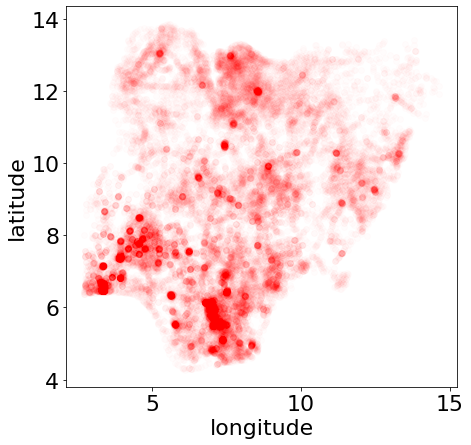

In [119]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(data.longitude, data.latitude, 'ro', alpha=0.01)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

mlai.write_figure('nigerian-health-facilities.png', directory='./ml')

<img class="" src="https://mlatcl.github.io/dsa/./slides/diagrams//ml/nigerian-health-facilities.png" style="width:60%">

Figure: <i>Location of the over thirty-four thousand health facilities
registered in the NMIS data across Nigeria. Each facility plotted
according to its latitude and longitude.</i>

In [120]:
hospital_data = data

## Administrative Zone Geo Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-spatial-join.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-spatial-join.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

A very common operation is the need to map from locations in a country
to the administrative regions. If we were building a ride sharing app,
we might also want to map riders to locations in the city, so that we
could know how many riders we had in different city areas.

Administrative regions have various names like cities, counties,
districts, or states. These conversions for the administrative regions
are important for getting the right information to the right people.

Of course, if we had a knowledgeable Nigerian, we could ask her about
what the right location for each of these health facilities is, which
state is it in? But given that we have the latitude and longitude, we
should be able to find out automatically what the different states are.

This is where “geo” data becomes important. We need to download a
dataset that stores the location of the different states in Nigeria.
These files are known as ‘outline’ files. Because they draw the
different states of different countries in outline.

There are special databases for storing this type of information, the
database we are using is in the `gdb` or GeoDataBase format. It comes in
a zip file. Let’s download the outline files for the Nigerian states.
They have been made available by the [Humanitarian Data
Exchange](https://data.humdata.org/), you can also find other states
data from the same site.

## Nigerian Administrative Zones Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-administrative-zones-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-administrative-zones-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

For ease of use we’ve packaged this data set in the `pods` library

In [121]:
data = pods.datasets.nigerian_administrative_zones()['Y']
data.head()

,admin1Name_en,admin1Pcode,admin1RefName,admin1AltName1_en,admin1AltName2_en,admin0Name_en,admin0Pcode,date,validOn,validTo,Shape_Length,Shape_Area,geometry
0,Abia,NG001,Abia,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,4.695135,0.396543,"MULTIPOLYGON (((7.38681 6.03667, 7.38729 6.036..."
1,Adamawa,NG002,Adamawa,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,11.525443,3.113007,"MULTIPOLYGON (((13.62129 10.94823, 13.62592 10..."
2,Akwa Ibom,NG003,Akwa Ibom,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,5.263830,0.549476,"MULTIPOLYGON (((8.34482 4.61140, 8.34496 4.609..."
3,Anambra,NG004,Anambra,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,3.595960,0.392661,"MULTIPOLYGON (((6.93254 6.71090, 6.93167 6.698..."
4,Bauchi,NG005,Bauchi,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,13.952005,4.011018,"MULTIPOLYGON (((10.75125 12.46148, 10.75615 12..."


Alternatively you can access the data directly with the following
commands.

``` python
import zipfile

admin_zones_url = 'https://data.humdata.org/dataset/81ac1d38-f603-4a98-804d-325c658599a3/resource/0bc2f7bb-9ff6-40db-a569-1989b8ffd3bc/download/nga_admbnda_osgof_eha_itos.gdb.zip'
_, msg = urllib.request.urlretrieve(admin_zones_url, 'nga_admbnda_osgof_eha_itos.gdb.zip')
with zipfile.ZipFile('/content/nga_admbnda_osgof_eha_itos.gdb.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/nga_admbnda_osgof_eha_itos.gdb')

import geopandas as gpd
import fiona

states_file = "./nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

layers = fiona.listlayers(states_file)
data = gpd.read_file(states_file, layer=1)
data.crs = "EPSG:4326"
data = data.set_index('admin1Name_en')
    
```

In [122]:
import matplotlib.pyplot as plt
import mlai
import mlai.plot as plot

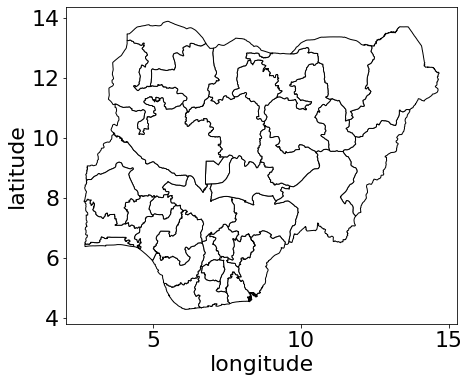

In [123]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
data.plot(ax=ax, color='white', edgecolor='black')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

mlai.write_figure('nigerian-state-borders.svg', directory='./ml')

<img src="https://mlatcl.github.io/dsa/./slides/diagrams//ml/nigerian-state-borders.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>Border locations for the thirty-six different states of
Nigeria.</i>

In [124]:
zones_gdf = data

Now we have this data of the outlines of the different states in
Nigeria.

The next thing we need to know is how these health facilities map onto
different states in Nigeria. Without “binning” facilities somehow, it’s
difficult to effectively see how they are distributed across the
country.

We do this by finding a “geo” dataset that contains the spatial outlay
of Nigerian states by latitude/longitude coordinates. The dataset we use
is of the “gdb” (GeoDataBase) type and comes as a zip file. We don’t
need to worry much about this datatype for this notebook, only noting
that geopandas knows how to load in the dataset, and that it contains
different “layers” for the same map. In this case, each layer is a
different degree of granularity of the political boundaries, with layer
0 being the whole country, 1 is by state, or 2 is by local government.
We’ll go with a state level view for simplicity, but as an excercise you
can change it to layer 2 to view the distribution by local government.

Once we have these `MultiPolygon` objects that define the boundaries of
different states, we can perform a spatial join (sjoin) from the
coordinates of individual health facilities (which we already converted
to the appropriate `Point` type when moving the health data to a
GeoDataFrame.)

## Joining a GeoDataFrame

The first database join we’re going to do is a special one, it’s a
‘spatial join.’ We’re going to join the locations of the hospitals with
their states.

This join is unusual because it requires some mathematics to get right.
The outline files give us the borders of the different states in
latitude and longitude, the health facilities have given locations in
the country.

A spatial join involves finding out which state each health facility
belongs to. Fortunately, the mathematics you need is already programmed
for you in GeoPandas. That means all we need to do is convert our
`pandas` dataframe of health facilities into a `GeoDataFrame` which
allows us to do the spatial join.

First, we convert the hospital data to a `geopandas` data frame.

In [125]:
import geopandas as gpd

In [126]:
geometry=gpd.points_from_xy(hospital_data.longitude, hospital_data.latitude)
hosp_gdf = gpd.GeoDataFrame(hospital_data, 
                            geometry=geometry)
hosp_gdf.crs = "EPSG:4326"

There are some technial details here: the `crs` refers to the coordinate
system in use by a particular GeoDataFrame. `EPSG:4326` is the standard
coordinate system of latitude/longitude.

## Your First Join: Converting GPS Coordinates to States

Now we have the data in the `GeoPandas` format, we can start converting
into states. We will use the [`fiona`](https://pypi.org/project/Fiona/)
library for reading the right layers from the files. Before we do the
join, lets plot the location of health centers and states on the same
map.

In [127]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_gdf.crs = "EPSG:4326"
nigeria_gdf = world_gdf[(world_gdf['name'] == 'Nigeria')]

In [128]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

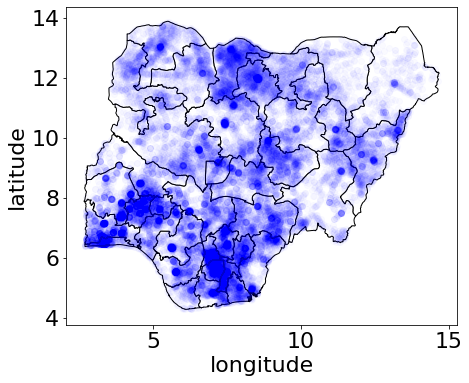

In [129]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
nigeria_gdf.plot(ax=ax, color='white', edgecolor='black', alpha=0)
zones_gdf.plot(ax=ax, color='white', edgecolor='black')
hosp_gdf.plot(ax=ax, color='b', alpha=0.02)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

mlai.write_figure('nigeria-states-and-health-facilities.svg', directory='./ml')

<img src="https://mlatcl.github.io/dsa/./slides/diagrams//ml/nigeria-states-and-health-facilities.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>The outline of the thirty-six different states of nigeria
with the location sof the health centers plotted on the map.</i>

## Performing the Spatial Join

We’ve now plotted the different health center locations across the
states. You can clearly see that each of the dots falls within a
different state. For helping the visualization, we’ve made the dots
somewhat transparent (we set the `alpha` in the plot). This means that
we can see the regions where there are more health centers, you should
be able to spot where the major cities in Nigeria are given the
increased number of health centers in those regions.

Of course, we can now see by eye, which of the states each of the health
centers belongs to. But we want the computer to do our join for us.
`GeoPandas` provides us with the spatial join. Here we’re going to do a
[`left` or `outer`
join](https://en.wikipedia.org/wiki/Join_(SQL)#Left_outer_join).

In [130]:
from geopandas.tools import sjoin

We have two GeoPandas data frames, `hosp_gdf` and `zones_gdf`. Let’s
have a look at the columns the contain.

In [131]:
hosp_gdf.columns

Index(['facility_name', 'facility_type_display',
       'maternal_health_delivery_services', 'emergency_transport',
       'skilled_birth_attendant', 'num_chews_fulltime', 'phcn_electricity',
       'c_section_yn', 'child_health_measles_immun_calc',
       'num_nurses_fulltime', 'num_nursemidwives_fulltime',
       'num_doctors_fulltime', 'date_of_survey', 'facility_id', 'community',
       'ward', 'management', 'improved_water_supply', 'improved_sanitation',
       'vaccines_fridge_freezer', 'antenatal_care_yn', 'family_planning_yn',
       'malaria_treatment_artemisinin', 'sector', 'formhub_photo_id', 'gps',
       'survey_id', 'unique_lga', 'latitude', 'longitude', 'geometry'],
      dtype='object')

We can see that this is the GeoDataFrame containing the information
about the hospital. Now let’s have a look at the `zones_gdf` data frame.

In [132]:
zones_gdf.columns

Index(['admin1Name_en', 'admin1Pcode', 'admin1RefName', 'admin1AltName1_en',
       'admin1AltName2_en', 'admin0Name_en', 'admin0Pcode', 'date', 'validOn',
       'validTo', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

You can see that this data frame has a different set of columns. It has
all the different administrative regions. But there is one column name
that overlaps. We can find it by looking for the intersection between
the two sets.

In [133]:
set(hosp_gdf.columns).intersection(set(zones_gdf.columns))

{'geometry'}

Here we’ve converted the lists of columns into python ‘sets,’ and then
looked for the intersection. The *join* will occur on the intersection
between these columns. It will try and match the geometry of the
hospitals (their location) to the geometry of the states (their
outlines). This match is done in one line in GeoPandas.

We’re having to use GeoPandas because this join is a special one based
on geographical locations, if the join was on customer name or some
other discrete variable, we could do the join in pandas or directly in
SQL.

In [134]:
hosp_state_joined = sjoin(hosp_gdf, zones_gdf, how='left')

The intersection of the two data frames indicates how the two data
frames will be joined (if there’s no intersection, they can’t be
joined). It’s like indicating the two holes that would need to be bolted
together on two pieces of metal. If the holes don’t match, the join
can’t be done. There has to be an intersection.

But what will the result look like? Well, the join should be the ‘union’
of the two data frames. We can have a look at what the union should be
by (again) converting the columns to sets.

In [135]:
set(hosp_gdf.columns).union(set(zones_gdf.columns))

{'Shape_Area',
 'Shape_Length',
 'admin0Name_en',
 'admin0Pcode',
 'admin1AltName1_en',
 'admin1AltName2_en',
 'admin1Name_en',
 'admin1Pcode',
 'admin1RefName',
 'antenatal_care_yn',
 'c_section_yn',
 'child_health_measles_immun_calc',
 'community',
 'date',
 'date_of_survey',
 'emergency_transport',
 'facility_id',
 'facility_name',
 'facility_type_display',
 'family_planning_yn',
 'formhub_photo_id',
 'geometry',
 'gps',
 'improved_sanitation',
 'improved_water_supply',
 'latitude',
 'longitude',
 'malaria_treatment_artemisinin',
 'management',
 'maternal_health_delivery_services',
 'num_chews_fulltime',
 'num_doctors_fulltime',
 'num_nursemidwives_fulltime',
 'num_nurses_fulltime',
 'phcn_electricity',
 'sector',
 'skilled_birth_attendant',
 'survey_id',
 'unique_lga',
 'vaccines_fridge_freezer',
 'validOn',
 'validTo',
 'ward'}

That gives a list of all the columns (notice that ‘geometry’ only
appears once).

Let’s check that’s what the join command did, by looking at the columns
of our new data frame, `hosp_state_joined`. Notice also that there’s a
new column: `index_right`. The two original data bases had separate
indices. The `index_right` column represents the index from the
`zones_gdf`, which is the Nigerian state.

In [136]:
set(hosp_state_joined.columns)

{'Shape_Area',
 'Shape_Length',
 'admin0Name_en',
 'admin0Pcode',
 'admin1AltName1_en',
 'admin1AltName2_en',
 'admin1Name_en',
 'admin1Pcode',
 'admin1RefName',
 'antenatal_care_yn',
 'c_section_yn',
 'child_health_measles_immun_calc',
 'community',
 'date',
 'date_of_survey',
 'emergency_transport',
 'facility_id',
 'facility_name',
 'facility_type_display',
 'family_planning_yn',
 'formhub_photo_id',
 'geometry',
 'gps',
 'improved_sanitation',
 'improved_water_supply',
 'index_right',
 'latitude',
 'longitude',
 'malaria_treatment_artemisinin',
 'management',
 'maternal_health_delivery_services',
 'num_chews_fulltime',
 'num_doctors_fulltime',
 'num_nursemidwives_fulltime',
 'num_nurses_fulltime',
 'phcn_electricity',
 'sector',
 'skilled_birth_attendant',
 'survey_id',
 'unique_lga',
 'vaccines_fridge_freezer',
 'validOn',
 'validTo',
 'ward'}

Great! They are all there! We have completed our join. We had two
separate data frames with information about states and information about
hospitals. But by performing an ‘outer’ or a ‘left’ join, we now have a
single data frame with all the information in the same place! Let’s have
a look at the first frew entries in the new data frame.

In [137]:
hosp_state_joined.head()

,facility_name,facility_type_display,maternal_health_delivery_services,emergency_transport,skilled_birth_attendant,num_chews_fulltime,phcn_electricity,c_section_yn,child_health_measles_immun_calc,num_nurses_fulltime,...,admin1RefName,admin1AltName1_en,admin1AltName2_en,admin0Name_en,admin0Pcode,date,validOn,validTo,Shape_Length,Shape_Area
0,HEALTH POST KAGBANG,Health Post,True,True,False,1.0,True,False,True,0.0,...,Cross River,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,8.779796,1.711218
1,Alhari Clinic,Primary Health Centre (PHC),True,True,True,4.0,True,False,True,1.0,...,Nasarawa,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,9.537188,2.197927
2,Primary health centre umukuru okehi,Basic Health Centre / Primary Health Clinic,True,True,True,2.0,True,True,True,4.0,...,Rivers,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,5.814545,0.830196
3,PHC EHOM CENTRAL,Primary Health Centre (PHC),True,False,False,2.0,False,False,True,0.0,...,Cross River,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,8.779796,1.711218
4,Health post,Health Post,True,False,False,0.0,False,False,True,0.0,...,Cross River,None,None,Nigeria,NG,2016-11-29T00:00:00+00:00,2016-12-15T00:00:00+00:00,None,8.779796,1.711218


## SQL Database

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-sql.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-sql.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Our first join was a special one, because it involved spatial data. That
meant using the special `gdb` format and the `GeoPandas` tool for
manipulating that data. But we’ve now saved our updated data in a new
file.

To do this, we use the command line utility that comes standard for
SQLite database creation. SQLite is a simple database that’s useful for
playing with database commands on your local machine. For a real system,
you would need to set up a server to run the database. The server is a
separate machine with the job of answering database queries. SQLite
pretends to be a proper database but doesn’t require us to go to the
extra work of setting up a server. Popular SQL server software includes
[`MariaDB`](https://mariadb.org/) which is open source, or [Microsoft’s
SQL Server](https://www.microsoft.com/en-gb/sql-server/sql-server-2019).

A typical machine learning installation might have you running a
database from a cloud service (such as AWS, Azure or Google Cloud
Platform). That cloud service would host the database for you, and you
would pay according to the number of queries made.

Many start-up companies were formed on the back of a `MySQL` server
hosted on top of AWS. Although since MySQL was sold to Sun, and then
passed on to Oracle, the open source community has turned its attention
to `MariaDB`, here’s the [AWS instructions on how to set up
`MariaDB`](https://aws.amazon.com/getting-started/hands-on/create-mariadb-db/).

If you were designing your own ride hailing app, or any other major
commercial software you would want to investigate whether you would need
to set up a central SQL server in one of these frameworks.

Today though, we’ll just stick to SQLite which gives you a sense of the
database without the time and expense of setting it up on the cloud. As
well as showing you the SQL commands (which is often what’s used in a
production ML system) we’ll also give the equivalent `pandas` commands,
which would often be what you would use when you’re doing data analysis
in `python` and `Jupyter`.

## Create the SQLite Database

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-sqlite.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-sqlite.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The beautiful thing about SQLite is that it allows us to play with SQL
without going to the work of setting up a proper SQL server. Creating a
data base in SQLite is as simple as writing a new file. To create the
database, we’ll first write our joined data to a CSV file, then we’ll
use a little utility to convert our hospital database into a SQLite
database.

In [138]:
hosp_state_joined.to_csv('facilities.csv')

In [139]:
%pip install csv-to-sqlite

Note: you may need to restart the kernel to use updated packages.


In [140]:
!csv-to-sqlite -f facilities.csv -t full -o db.sqlite

Error on table facilities.csv: 
 table [facilities] already exists
Written 0 rows into 1 tables in 0.427 seconds


Rather than being installed on a separate server, SQLite simply stores
the database locally in a file called `db.sqlite`.

In the database there can be several ‘tables.’ Each table can be thought
of as like a separate dataframe. The table name we’ve just saved is
‘hospitals_zones_joined.’

## Accessing the SQL Database

Now that we have a SQL database, we can create a connection to it and
query it using SQL commands. Let’s try to simply select the data we
wrote to it, to make sure it’s the same.

Start by making a connection to the database. This will often be done
via remote connections, but for this example we’ll connect locally to
the database using the filepath directly.

To access a data base, the first thing that is made is a connection.
Then SQL is used to extract the information required. A typical SQL
command is `SELECT`. It allows us to extract rows from a given table. It
operates a bit like the `.head()` method in `pandas`, it will return the
first `N` rows (by default the `.head()` command returns the first 5
rows, but you can set `N` to whatever you like. Here we’ve included a
default value of 5 to make it match the `pandas` command.

We do this using an `execute` command on the connection.

Typically, its good software engineering practice to ‘wrap’ the database
command in some python code. This allows the commands to be maintained.
Below we wrap the SQL command

    SELECT * FROM [table_name] LIMIT : N

in python code. This SQL command selects the first `N` entries from a
given database called `table_name`.

We can pass the `table_name` and number of rows, `n`, to the python
command.

In [141]:
import sqlite3

In [142]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

In [143]:
conn = create_connection("db.sqlite")

Now that we have a connection, we can write a command and pass it to the
database.

To access a data base, the first thing that is made is a connection.
Then SQL is used to extract the information required. A typical SQL
command is `SELECT`. It allows us to extract rows from a given table. It
operates a bit like the `.head()` method in `pandas`, it will return the
first `N` rows (by default the `.head()` command returns the first 5
rows, but you can set `N` to whatever you like. Here we’ve included a
default value of 5 to make it match the `pandas` command.

The python library, `sqlite3`, allows us to access the SQL database
directly from python.

In [144]:
def select_top(conn, table,  n):
    """
    Query n first rows of the table
    :param conn: the Connection object
    :param table: The table to query
    :param n: Number of rows to query
    """
    cur = conn.cursor()
    cur.execute(f"SELECT * FROM [{table}] LIMIT :limitNum", {"limitNum": n})

    rows = cur.fetchall()
    return rows

Let’s have a go at calling the command to extract the first three
facilities from our health center database. Let’s try creating a
function that does the same thing the pandas `.head()` method does so we
can inspect our database.

In [145]:
def head(conn, table, n=5):
  rows = select_top(conn, table, n)
  for r in rows:
      print(r)

In [146]:
head(conn, 'facilities')

(0, 'HEALTH POST KAGBANG', 'Health Post', 'True', 'True', 'False', '1.0', 'True', 'False', 'True', '0.0', '0.0', '0.0', '2014-02-25', 'TSTEW', 'KAGBANG', 'UKPE', 'public', 'False', 'False', 'False', 'True', 'False', 'True', 'health', '1393335750723.jpg', '6.54340807 9.08470312 218.8000030517578 5.0', '451a0efb-5fa6-4bad-93cd-7cf19eb50833', 'cross_river_obudu', 6.54340807, 9.08470312, 'POINT (9.08470312 6.54340807)', '8.0', 'Cross River', 'NG009', 'Cross River', '', '', 'Nigeria', 'NG', '2016-11-29T00:00:00+00:00', '2016-12-15T00:00:00+00:00', '', '8.779795856881378', '1.7112182413769654')
(1, 'Alhari Clinic', 'Primary Health Centre (PHC)', 'True', 'True', 'True', '4.0', 'True', 'False', 'True', '1.0', '1.0', '1.0', '2014-04-23', 'HJHCB', 'Masaka', 'Karu', 'private', 'False', 'True', 'True', 'True', 'False', 'True', 'health', '1393316873034.jpg', '9.00720861 7.67780798 432.8999938964844 5.0', '5ddb68d6-02d2-44de-9df3-ebc840a1da42', 'nasarawa_karu', 9.00720861, 7.67780798, 'POINT (7.6778

Great! We now have the database in and some python functions that
operate on the data base by wrapping SQL commands.

We will return to the SQL command style after download and add the other
datasets to the database using a combination of `pandas` and the
database utilities.

Our next task will be to introduce data on COVID19 so that we can join
that to our other data sets.

## Covid Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-covid-join.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-covid-join.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Now we have the health data, we’re going to combine it with [data about
COVID-19 cases in Nigeria over
time](https://github.com/dsfsi/covid19africa). This data is kindly
provided by Africa open COVID-19 data working group, which [Elaine
Nsoesie](https://www.bu.edu/sph/profile/elaine-nsoesie/) has been
working with. The data is taken from Twitter, and only goes up until May
2020.

They provide their data in GitHub. We can access the cases we’re
interested in from the following URL.

For convenience, we’ll load the data into pandas first, but our next
step will be to create a new SQLite table containing the data. Then
we’ll join that table to our existing tables.

# Nigerian COVID Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-covid-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-covid-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

At the beginning of the COVID-19 outbreak, the Consortium for African
COVID-19 Data formed to bring together data from across the African
continent on COVID-19 cases (Marivate et al., 2020). These cases are
recorded in the following GitHub repository:
<https://github.com/dsfsi/covid19africa>.

For ease of use we’ve packaged this data set in the `pods` library

In [147]:
import pods

In [148]:
data = pods.datasets.nigerian_covid()['Y']
data.head()

,case_id,origin_case_id,date,age,gender,city,province/state,country,current_status,source,symptoms,date_onset_symptoms,date_admission_hospital,date_confirmation,underlying_conditions,travel_history_dates,travel_history_location,death_date,notes_for_discussion,Unnamed: 19
0,1,NaN,2020-02-27,44,Male,Ogun,Ogun,Nigeria,In recovery,www.bbc.com,NaN,NaT,2020-02-27,2020-02-27,No,NaN,Italy,NaT,Patient came in from Italy.,NaN
1,2,NaN,2020-03-09,NaN,NaN,Ogun,Ogun,Nigeria,In treatment,https://twitter.com/NCDCgov/status/12376418124...,NaN,2020-03-09,2020-03-09,2020-03-09,No,NaN,NaN,NaT,NaN,NaN
2,3,NaN,2020-03-16,30,Female,Lagos,Lagos,Nigeria,Clinically Stable,https://twitter.com/NCDCgov/status/12398485450...,"Fever, Cold, Cough",NaT,2020-03-17,2020-03-17,NaN,13-Mar-20,United Kingdom,NaT,Patient returned from trip to UK and was in 14...,NaN
3,4,NaN,2020-03-16,58,Male,Lagos,Lagos,Nigeria,NaN,https://twitter.com/NCDCgov/status/12405579967...,NaN,NaT,NaT,NaT,NaN,13-Mar-20,USA,NaT,Patient returned from travel to USA,NaN
4,5,NaN,2020-03-16,38,Female,NaN,Ekiti,Nigeria,NaN,https://twitter.com/NCDCgov/status/12405579967...,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,Patient made contact with traveler from the USA,NaN


Alternatively, you can access the data directly with the following
commands.

``` python
import urllib.request
import pandas as pd

urllib.request.urlretrieve('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv', 'line-list-nigeria.csv')
data = pd.read_csv('line-list-nigeria.csv', parse_dates=['date', 
                                                         'date_confirmation', 
                                                         'date_admission_hospital', 
                                                         'date_onset_symptoms',
                                                         'death_date'])
```

Once it is loaded in the data can be summarized using the `describe`
method in pandas.

In [149]:
data.describe()

,case_id,origin_case_id
count,6401.000000,0.0
mean,3201.000000,NaN
std,1847.953868,NaN
min,1.000000,NaN
25%,1601.000000,NaN
50%,3201.000000,NaN
75%,4801.000000,NaN
max,6401.000000,NaN


In [150]:
import matplotlib.pyplot as plt
import mlai
import mlai.plot as plot

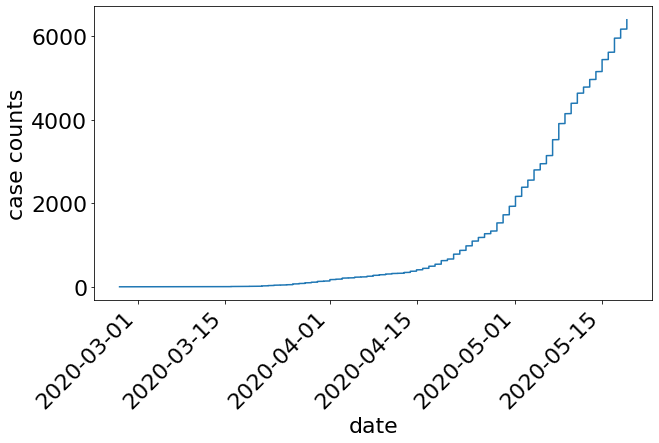

In [151]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
data['count_column'] = True
fig.autofmt_xdate(rotation=45)
ax.plot(data.date, data.count_column.cumsum())

ax.plot()
ax.set_xlabel('date')
ax.set_ylabel('case counts')

mlai.write_figure('nigerian-covid-data.svg', directory='./datasets')

<img src="https://mlatcl.github.io/dsa/./slides/diagrams//datasets/nigerian-covid-data.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Evolution of COVID-19 cases in Nigeria.</i>

In [152]:
covid_data=data
covid_data.to_csv('cases.csv')

Now we convert this CSV file we’ve downloaded into a new table in the
database file. We can do this, again, with the csv-to-sqlite script.

TK: include mariadb version

In [153]:
!csv-to-sqlite -f cases.csv -t full -o db.sqlite

Error on table cases.csv: 
 table [cases] already exists
Written 0 rows into 1 tables in 0.025 seconds


## Population Data

Now we have information about COVID cases, and we have information about
how many health centers and how many doctors and nurses there are in
each health center. But unless we understand how many people there are
in each state, then we cannot make decisions about where they may be
problems with the disease.

If we were running our ride hailing service, we would also need
information about how many people there were in different areas, so we
could understand what the *demand* for the boda boda rides might be.

To access the number of people we can get population statistics from the
[Humanitarian Data Exchange](https://data.humdata.org/).

We also want to have population data for each state in Nigeria, so that
we can see attributes like whether there are zones of high health
facility density but low population density.

## Population Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-population-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigerian-population-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Now we have information about COVID cases, and we have information about
how many health centers and how many doctors and nurses there are in
each health center. But unless we understand how many people there are
in each state, then we cannot make decisions about where they may be
problems with the disease.

If we were running our ride hailing service, we would also need
information about how many people there were in different areas, so we
could understand what the demand for the boda boda rides might be.

To access the number of people we can get population statistics from the
[Humanitarian Data Exchange](https://data.humdata.org/).

We also want to have population data for each state in Nigeria, so that
we can see attributes like whether there are zones of high health
facility density but low population density.

``` python
import urllib

pop_url = 'https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/d9fc551a-b5e4-4bed-9d0d-b047b6961817/download/nga_admpop_adm1_2020.csv'
_, msg = urllib.request.urlretrieve(pop_url,'nga_admpop_adm1_2020.csv')
data = pd.read_csv('nga_admpop_adm1_2020.csv')
```

To do joins with this data, we must first make sure that the columns
have the right names. The name should match the same name of the column
in our existing data. So we reset the column names, and the name of the
index, as follows.

``` python
data.dropna(axis=0, how='all', inplace=True)
data.dropna(axis=1, how='all', inplace=True)
data.rename(columns = {'ADM0_NAME':'admin0Name_en', 
                       'ADM0_PCODE' : 'admin0Pcode', 
                       'ADM1_NAME' : 'admin1Name_en', 
                       'ADM1_PCODE' : 'admin1Pcode', 
                       'T_TL' :'population'},
            inplace=True)
data["admin0Name_en"] = data["admin0Name_en"].str.title()
data["admin1Name_en"] = data["admin1Name_en"].str.title()
    
data = data.set_index('admin1Name_en')
```

In [154]:
data = pods.datasets.nigerian_population()['Y']

In [155]:
data.head()

,admin0Name_en,admin0Pcode,admin1Pcode,F_TL,M_TL,population,F_00_04,F_05_09,F_10_14,F_15_19,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
admin1Name_en,,,,,,,,,,,,,,,,,,,,,
Abia,Nigeria,NG,NG001,1937239.0,1941738.0,3878977.0,210483.0,215867.0,248705.0,235360.0,...,222947.0,194133.0,175852.0,134694.0,126513.0,84071.0,78976.0,48921.0,35513.0,19470.0
Adamawa,Nigeria,NG,NG002,2168252.0,2228347.0,4396599.0,372760.0,320576.0,273011.0,233204.0,...,225579.0,188995.0,143381.0,116482.0,94120.0,72897.0,58057.0,46415.0,27654.0,17161.0
Akwa ibom,Nigeria,NG,NG003,2789212.0,2876552.0,5665764.0,326260.0,342223.0,353787.0,329383.0,...,340402.0,288166.0,256081.0,190410.0,160830.0,125151.0,98786.0,53539.0,32155.0,15171.0
Anambra,Nigeria,NG,NG004,2932876.0,3003908.0,5936784.0,319470.0,334304.0,379733.0,357447.0,...,350214.0,302323.0,270660.0,201279.0,185087.0,122166.0,110187.0,64398.0,48022.0,23577.0
Bauchi,Nigeria,NG,NG005,3272516.0,3417618.0,6690134.0,639299.0,509011.0,402259.0,352254.0,...,322124.0,276823.0,193548.0,172873.0,109191.0,101830.0,60952.0,58276.0,31020.0,23856.0


In [156]:
pop_data=data

When doing this for real world data, you should also make sure that the
names used in the rows are the same across the different data bases. For
example, has someone decided to use an abbreviation for ‘Federal Capital
Territory’ and set it as ‘FCT.’ The computer won’t understand these are
the same states, and if you do a join with such data, you can get
duplicate entries or missing entries. This sort of thing happens a lot
in real world data and takes a lot of time to sort out. Fortunately, in
this case, the data is well curated, and we don’t have these problems.

## Save to database file

The next step is to add this new CSV file as an additional table in our
database.

## Computing per capita hospitals and COVID

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-covid-join.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_systems/includes/nigeria-nmis-covid-join.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The Minister of Health in Abuja may be interested in which states are
most vulnerable to COVID19. We now have all the information in our SQL
data bases to compute what our health center provision is per capita,
and what the COVID19 situation is.

To do this, we will use the `JOIN` operation from SQL and introduce a
new operation called `GROUPBY`.

### Joining in Pandas

As before, these operations can be done in pandas or GeoPandas. Before
we create the SQL commands, we’ll show how you can do that in pandas.

In `pandas`, the equivalent of a database table is a dataframe. So, the
JOIN operation takes two dataframes and joins them based on the key. The
key is that special shared column between the two tables. The place
where the ‘holes align’ so the two databases can be joined together.

In GeoPandas we used an outer join. In an outer join you keep all rows
from both tables, even if there is no match on the key. In an inner
join, you only keep the rows if the two tables have a matching key.

This is sometimes where problems can creep in. If in one table Abuja’s
state is encoded as ‘FCT’ or ‘FCT-Abuja,’ and in another table it’s
encoded as ‘Federal Capital Territory,’ they won’t match, and that data
wouldn’t appear in the joined table.

In simple terms, a JOIN operation takes two tables (or dataframes) and
combines them based on some key, in this case the index of the Pandas
data frame which is the state name.

In [157]:
zones_gdf.set_index("admin1Name_en", inplace=True)
pop_joined = zones_gdf.join(pop_data['population'], how='inner')

## GroupBy in Pandas

Our COVID19 data is in the form of individual cases. But we are
interested in total case counts for each state. There is a special data
base operation known as `GROUP BY` for collecting information about the
individual states. The type of information you might want could be a
sum, the maximum value, an average, the minimum value. We can use a
GroupBy operation in `pandas` and SQL to summarize the counts of covid
cases in each state.

A `GROUPBY` operation groups rows with the same key (in this case
‘province/state’) into separate objects, that we can operate on further
such as to count the rows in each group, or to sum or take the mean over
the values in some column (imagine each case row had the age of the
patient, and you were interested in the mean age of patients.)

In [158]:
covid_cases_by_state = covid_data.groupby(['province/state']).count()['case_id']

The `.groupby()` method on the dataframe has now given us a new data
series that contains the total number of covid cases in each state. We
can examine it to check we have something sensible.

In [159]:
covid_cases_by_state

province/state
Abia            5
Abuja         427
Adamawa        26
Akwa Ibom      18
Anambra         5
Bauchi        224
Bayelsa         7
Benue           5
Borno         227
Delta          27
Ebonyi         13
Edo           119
Ekiti          19
Enugu          16
Gombe         136
Imo             7
Jigawa        205
Kaduna        152
Kano          842
Katsina       281
Kebbi          32
Kwara          65
Lagos        2756
Nasarawa       34
Niger          22
Ogun          177
Ondo           20
Osun           42
Oyo           143
Plateau        50
Rivers         53
Sokoto        113
Taraba         17
Yobe           32
Zamfara        84
Name: case_id, dtype: int64

Now we have this new data series, it can be added to the pandas
dataframe as a new column.

In [160]:
pop_joined['covid_cases_by_state'] = covid_cases_by_state

The spatial join we did on the original data frame to obtain
hosp_state_joined introduced a new column, `index_right` that contains
the state of each of the hospitals. Let’s have a quick look at it below.

In [161]:
hosp_state_joined['index_right']

0         8.0
1        25.0
2        32.0
3         8.0
4         8.0
         ... 
34134    28.0
34135     8.0
34136    13.0
34137    21.0
34138     8.0
Name: index_right, Length: 34139, dtype: float64

To count the hospitals in each of the states, we first create a grouped
series where we’ve grouped on these states.

In [162]:
grouped = hosp_state_joined.groupby('index_right')

This python operation now goes through each of the groups and counts how
many hospitals there are in each state. It stores the result in a
dictionary. If you’re new to python, then to understand this code you
need to understand what a ‘dictionary comprehension’ is. In this case
the dictionary comprehension is being used to create a python dictionary
of states and total hospital counts. That’s then being converted into a
`pandas` Data Series and added to the `pop_joined` dataframe.

In [163]:
import pandas as pd

In [164]:
counted_groups = {k: len(v) for k, v in grouped.groups.items()}
pop_joined['hosp_state'] = pd.Series(counted_groups)

For convenience, we can now add a new data series to the data frame that
contains the per capita information about hospitals. that makes it easy
to retrieve later.

In [165]:
pop_joined['hosp_per_capita_10k'] = (pop_joined['hosp_state'] * 10000 )/ pop_joined['population']

## SQL-style

That’s the `pandas` approach to doing it. But `pandas` itself is
inspired by database languages, in particular relational databases such
as SQL. To do these types of joins at scale, e.g., for a ride hailing
app, we need to do these joins in a database.

As before, we’ll wrap the underlying SQL commands with a convenient
python command.

What you see below gives the full SQL command. There is a [`SELECT`
command](https://www.w3schools.com/sql/sql_select.asp), which extracts
`FROM` a particular table. It then completes an
[`INNER JOIN`](https://www.w3schools.com/sql/sql_join_inner.asp) using
particular columns (`provice/state` and `index_right`)

In [166]:
def join_counts(conn):
    """
    Calculate counts of cases and facilities per state, join results
    """
    cur = conn.cursor()
    cur.execute("""
                SELECT ct.[province/state] as [state], ct.[case_count], ft.[facility_count]
                FROM
                    (SELECT [province/state], COUNT(*) as [case_count] FROM [cases] GROUP BY [province/state]) ct
                INNER JOIN 
                    (SELECT [index_right], COUNT(*) as [facility_count] FROM [facilities] GROUP BY [index_right]) ft
                ON
                    ct.[province/state] = ft.[index_right]
                """)

    rows = cur.fetchall()
    return rows

Now we’ve created our python wrapper, we can connect to the data base
and run our SQL command on the database using the wrapper.

TK: Fix this to be a connection to the mariadb also.

In [167]:
conn = create_connection("db.sqlite")

In [168]:
state_cases_hosps = join_counts(conn)

In [169]:
for row in state_cases_hosps:
    print("State {} \t\t Covid Cases {} \t\t Health Facilities {}".format(row[0], row[1], row[2]))

Text(0.5, 1.0, 'Population of Nigerian States')

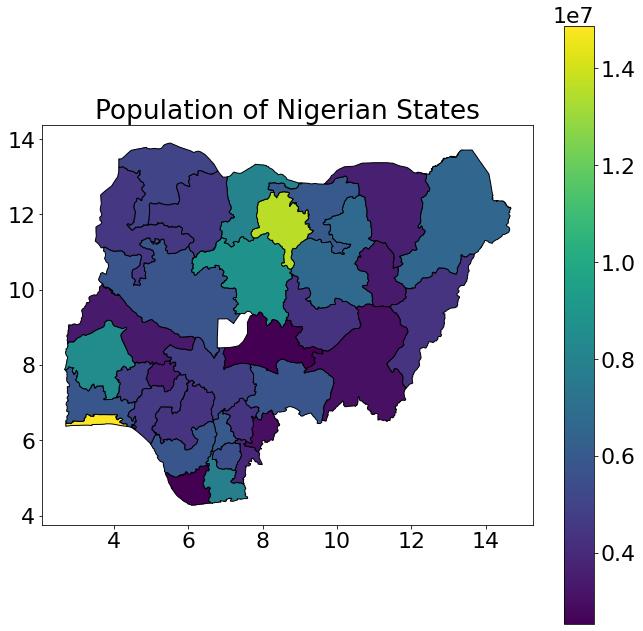

In [170]:
base = nigeria_gdf.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
pop_joined.plot(ax=base, column='population', edgecolor='black', legend=True)
base.set_title("Population of Nigerian States")

Text(0.5, 1.0, 'Hospitals Per Capita (10k) of Nigerian States')

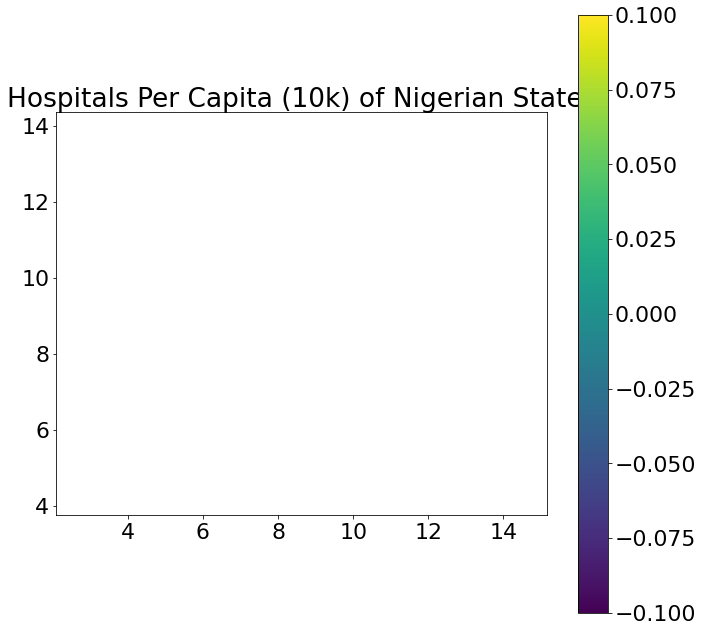

In [171]:
base = nigeria_gdf.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
pop_joined.plot(ax=base, column='hosp_per_capita_10k', edgecolor='black', legend=True)
base.set_title("Hospitals Per Capita (10k) of Nigerian States")

In [172]:
# pop_joined['cases_per_capita_10k'] = ???
# pop_joined['cases_per_facility'] = ???

KeyError: 'cases_per_capita_10k'

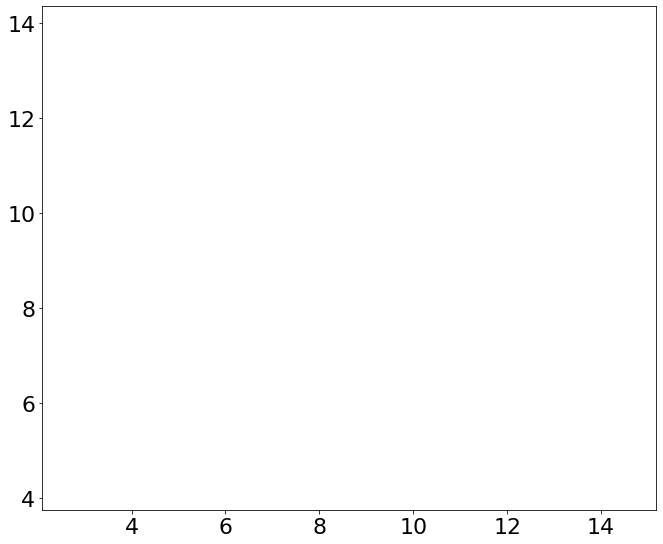

In [173]:
base = nigeria_gdf.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
pop_joined.plot(ax=base, column='cases_per_capita_10k', edgecolor='black', legend=True)
base.set_title("Covid Cases Per Capita (10k) of Nigerian States")

In [ ]:
base = nigeria_gdf.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
pop_joined.plot(ax=base, column='covid_cases_by_state', edgecolor='black', legend=True)
base.set_title("Covid Cases by State")

In [ ]:
base = nigeria_gdf.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
pop_joined.plot(ax=base, column='cases_per_facility', edgecolor='black', legend=True)
base.set_title("Covid Cases per Health Facility")

## Thanks!

For more information on these subjects and more you might want to check
the following resources.

-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

## References

Marivate, V., Nsoesie, E., Bekele, E., Africa open COVID-19 data working
group, 2020. <span class="nocase">Coronavirus COVID-19 (2019-nCoV) Data
Repository for Africa</span>. <https://doi.org/10.5281/zenodo.3757554>

The Office of the Senior Special Assistant to the President on the
Millennium Development Goals (OSSAP-MDGs), Columbia University, 2014.
Nigeria NMIS facility database.